In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the map for NYGrid thermal gen data
map_UnitType = {
    "Combustion Turbine" : "CT",
    "Combined Cycle" : "CC",
    "Internal Combustion" : "IC",
    "Steam Turbine" : "ST",
    "Jet Engine" : "GT",
    "Nuclear" : "ST",
}

map_FuelType = {
    "Kerosene" : "KER",
    "Natural Gas" : "NG",
    "Fuel Oil 2" : "DFO",
    "Coal" : "COAL",
    "Fuel Oil 6" : "RFO",
    "Nuclear" : "NUC",
}

In [3]:
NY_gen = pd.read_csv('Data/gen_prop.csv')
df_geninfo = pd.read_csv('Data/geninfo.csv')
NY_gen.drop(['GEN_BUS','PG', 'QG', 'QMAX', 'QMIN', 'VG','MBASE','GEN_STATUS', 'PC1','PC2','QC1MIN','QC1MX','QC2MIN','QC2MAX','RAMP_AGC','RAMP_30','RAMP_Q','APF','GEN_ZONE'], axis=1, inplace=True)
NY_gen = NY_gen[NY_gen.index < 233]
NY_gen["PRIMEMOVER"] = [map_UnitType[i] for i in NY_gen.GEN_FUEL]
Energy_Source = [map_FuelType[i] for i in df_geninfo.FuelType]
while len(Energy_Source) < NY_gen.shape[0]:
    Energy_Source.append("NUC")
NY_gen["Energy_Source_1 (Fuel)"] = Energy_Source
NY_gen["RAMP_min"] = NY_gen["RAMP_10"]/10

In [4]:
PERC_gen = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/PERC_gen.csv')
PERC_gen.drop(['SEASONAL_CAPABILITY (MWs)', 'EFORD', 'CO2 rate (lbs/MWh)',
       'NOx rate (lbs/MWh)', 'SO2 rate (lbs/MWh)'], axis=1, inplace=True)

In [5]:
# Scale the data to (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(PERC_gen[['NAMEPLATE (MWs)', 'Economic Minimum (MW)', 'RAMP UP (MW/min)']])
PERC_gen_scaled = pd.DataFrame(df_scaled, columns=['scale_nameplate', 'scale_min', 'scale_ramp'])

ny_df_scaled = scaler.fit_transform(NY_gen[['PMAX', 'PMIN', 'RAMP_min']])
NY_gen_scaled = pd.DataFrame(ny_df_scaled, columns=['scale_nameplate', 'scale_min', 'scale_ramp'])

In [6]:
similar_gen = []
for i in range(NY_gen.shape[0]):
    pm = NY_gen.PRIMEMOVER[i]
    fuel = NY_gen["Energy_Source_1 (Fuel)"][i]
    ramp = NY_gen["RAMP_min"][i]
    if fuel == "COAL":
        fuel = ["BIT", "LIG", "SUB", "WC"]
        idx = PERC_gen[(PERC_gen["PRIMEMOVER"] == pm) & (PERC_gen["Energy_Source_1 (Fuel)"].isin(fuel))].index
    else:
        idx = PERC_gen[(PERC_gen["PRIMEMOVER"] == pm) & (PERC_gen["Energy_Source_1 (Fuel)"] == fuel)].index
    if len(idx) == 0:
        idx = PERC_gen[(PERC_gen["PRIMEMOVER"] == pm)].index
    if len(idx) == 0:
        ValueError("No generator with the same primemover found")
    cosine_similarity = []
    for j in idx:
        val = np.dot(PERC_gen_scaled.iloc[j, 1:4], NY_gen_scaled.iloc[i, 1:4])/(np.linalg.norm(PERC_gen_scaled.iloc[j, 1:4])*np.linalg.norm(NY_gen_scaled.iloc[i, 1:4]))
        cosine_similarity.append(val)
    similar_gen.append(idx[np.argmax(cosine_similarity)])
NY_gen["SimGEN_PERCidx"] = similar_gen

/var/folders/0x/zhtp9mkn7n1gpdtws1748ccw0000gn/T/ipykernel_63631/657761340.py:17: RuntimeWarning: invalid value encountered in double_scalars
  val = np.dot(PERC_gen_scaled.iloc[j, 1:4], NY_gen_scaled.iloc[i, 1:4])/(np.linalg.norm(PERC_gen_scaled.iloc[j, 1:4])*np.linalg.norm(NY_gen_scaled.iloc[i, 1:4]))


In [8]:
StartUpCost = []
MinDownTime = []
MinRunTime = []
for i in range(NY_gen.shape[0]):
    idx = NY_gen['SimGEN_PERCidx'][i]
    StartUpCost.append(PERC_gen['Cold Start Cost ($)'][idx])
    MinDownTime.append(PERC_gen['MIN_DOWN_TIME (hr)'][idx])
    MinRunTime.append(PERC_gen['MIN_RUN_TIME (hr)'][idx])
NY_gen["StartUpCost"] = StartUpCost
NY_gen["MinDownTime"] = MinDownTime
NY_gen["MinRunTime"] = MinRunTime

In [9]:
NY_gen.to_csv('Data/NY_gen.csv', index=False)

In [10]:
NY_gen

,Unnamed: 0,GEN_NAME,PMAX,PMIN,RAMP_10,GEN_FUEL,PRIMEMOVER,Energy_Source_1 (Fuel),RAMP_min,SimGEN_PERCidx,StartUpCost,MinDownTime,MinRunTime
0,0,59 St. GT 1,17.1,0.0,17.10,Combustion Turbine,CT,KER,1.710,191,2520.42,2.0,3.0
1,1,74 St. GT 1,18.5,0.0,18.50,Combustion Turbine,CT,KER,1.850,191,2520.42,2.0,3.0
2,2,74 St. GT 2,18.5,0.0,18.50,Combustion Turbine,CT,KER,1.850,191,2520.42,2.0,3.0
3,3,Allegany,66.0,11.0,66.00,Combined Cycle,CC,NG,6.600,680,6994.00,4.0,6.0
4,4,Allied Frozen Storage,0.1,0.0,0.10,Internal Combustion,IC,NG,0.010,702,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,228,Nuclear_C_0,854.5,0.0,85.45,Nuclear,ST,NUC,8.545,584,0.00,168.0,168.0
229,229,Nuclear_C_1,629.0,0.0,62.90,Nuclear,ST,NUC,6.290,584,0.00,168.0,168.0
230,230,Nuclear_C_2,1299.0,0.0,129.90,Nuclear,ST,NUC,12.990,584,0.00,168.0,168.0
231,231,Nuclear_H_0,1025.9,0.0,102.59,Nuclear,ST,NUC,10.259,584,0.00,168.0,168.0


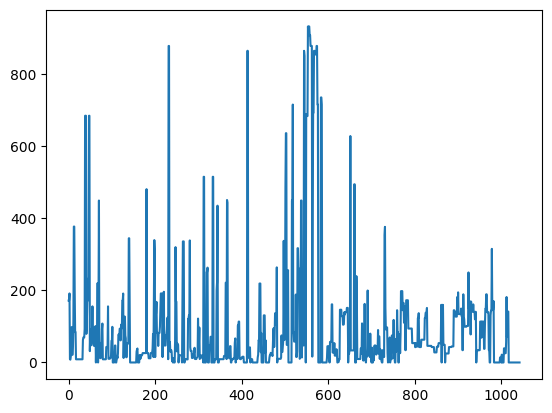

In [77]:
plt.plot(PERC_gen['Economic Minimum (MW)'])

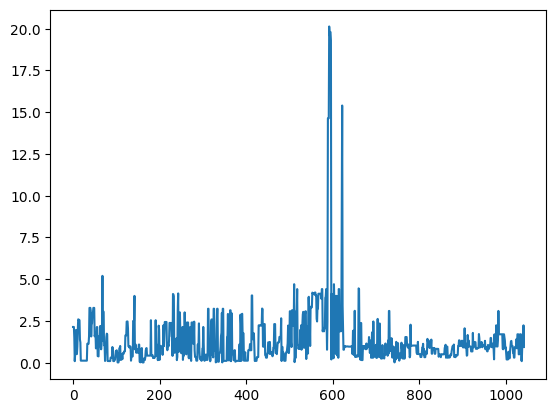

In [78]:
plt.plot(PERC_gen["RAMP UP (MW/min)"])